<a href="https://colab.research.google.com/github/nhattientran/stackoverflow-classification-question/blob/master/StackOverFlow_official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 : Đọc dữ liệu

In [5]:
import pandas as pd
url = "https://github.com/nhattientran/stackoverflow-classification-question/blob/master/dataset/full_dataset_v3.csv?raw=true"
data = pd.read_csv(url,delimiter=";")

#2 : Thống kê dữ liệu

In [6]:
data.head()

,title,id_stack,tags,views,score,done,label
0,Using entries from other kivy classes,61881920,"['python', 'python-3.x', 'kivy']",12,0,False,python
1,Package python software with pylucene dependency,61896481,"['python', 'docker', 'pip', 'dependencies', 'p...",7,1,False,python
2,Extracting time with regex from a string,61894597,"['python', 'regex']",29,3,False,python
3,How do I add specific headers before each form...,61896721,"['python', 'django']",4,0,False,python
4,Barplot from a dataframe using a column to set...,61896506,"['python', 'pandas', 'bar-chart', 'seaborn', '...",12,0,True,python


In [7]:
data.tail()

,title,id_stack,tags,views,score,done,label
75329,Php Monolog udp SocketHandler packet size,62436746,"['php', 'udp', 'logstash', 'monolog']",16,1,False,php
75330,PHP CURL issue | Header Context Type is not se...,62435600,"['php', 'curl']",11,0,False,php
75331,How can I delete data of single row in PHP dyn...,62436423,"['php', 'html']",15,-3,False,php
75332,How to make custom associative array using an ...,62435957,"['php', 'arrays', 'laravel', 'associative-array']",29,0,True,php
75333,base64 image to imagecreatefromstring() losing...,42385529,"['javascript', 'php', 'base64', 'filereader', ...",817,1,True,php


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75334 entries, 0 to 75333
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     75334 non-null  object
 1   id_stack  75334 non-null  int64 
 2   tags      75334 non-null  object
 3   views     75334 non-null  int64 
 4   score     75334 non-null  int64 
 5   done      75334 non-null  bool  
 6   label     75334 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 3.5+ MB


In [9]:
data.shape

(75334, 7)

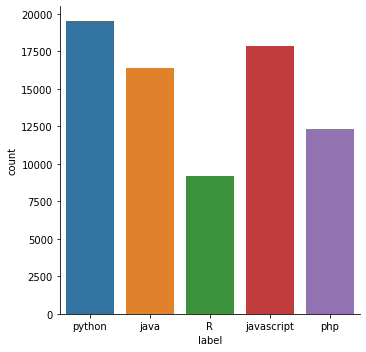

In [10]:
import seaborn as sns
sns.catplot(x="label",kind="count",data=data)

#3 : Tiền xử lý dữ liệu

**Text processing**

In [11]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
text = data['title']
def preprocessor(review):
  review=re.sub("[^a-zA-z]"," ",review)
  review = review.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if word not in stopwords.words("english")]
  review = " ".join(review)
  return review
text = text.apply(preprocessor)

**TfidfVectorizer**

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tf = CountVectorizer(min_df = 5,max_df = 0.8,max_features=3000)
X_tf = tf.fit_transform(text)

**CountVectorizer**

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv= cv.fit_transform(text)

**Word2Vec**

In [13]:
import gensim
sent = ([row.split() for row in text])
w2v = gensim.models.Word2Vec(sent,size=300,min_count=1,iter=10)

In [14]:
import numpy as np
embedding_matrix = np.zeros((len(w2v.wv.vocab) + 1, 300))
for i, vec in enumerate(w2v.wv.vectors):
  embedding_matrix[i] = vec

**Tokenizer**

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=len(w2v.wv.vocab)+1)
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20852 unique tokens.


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_wv = tokenizer.texts_to_sequences(text)
X_wv = pad_sequences(X_wv)
print('Shape of data tensor:', X_wv.shape)

Shape of data tensor: (75334, 29)


**Train test split**

In [17]:
from sklearn.model_selection import train_test_split
Y_ohe =pd.get_dummies(data['label'])
Y = data['label']

In [18]:
X_train_lstm, X_test_lstm,Y_train_ohe,Y_test_ohe = train_test_split(X_wv,Y_ohe,train_size=0.8,random_state=0) 

In [19]:
X_train_cv, X_test_cv,Y_train,Y_test = train_test_split(X_cv,Y,train_size=0.8,random_state=0) 

In [27]:
X_train_tf, X_test_tf,Y_train,Y_test = train_test_split(X_tf,Y,train_size=0.8,random_state=0) 

#4 : Huấn luyện mô hình

**LSTM**

In [20]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
lstm = keras.Sequential()
lstm.add(layers.Embedding(len(w2v.wv.vocab)+1,300,input_length=X_wv.shape[1],weights=[embedding_matrix]))
lstm.add(layers.LSTM(300))
lstm.add(layers.Dense(Y_ohe.shape[1],activation="sigmoid"))
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 300)           6971700   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 5)                 1505      
Total params: 7,694,405
Trainable params: 7,694,405
Non-trainable params: 0
_________________________________________________________________


In [21]:
lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [22]:
lstm.fit(X_train_lstm,Y_train_ohe,batch_size = 64 ,epochs=3)

Epoch 1/3
942/942 [==============================] - 45s 47ms/step - loss: 0.7482 - accuracy: 0.7098
Epoch 2/3
942/942 [==============================] - 43s 45ms/step - loss: 0.4570 - accuracy: 0.8331
Epoch 3/3
942/942 [==============================] - 43s 45ms/step - loss: 0.3564 - accuracy: 0.8715


**LogisticRegression**


In [23]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()
log_reg.fit(X_train_cv,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**SVM**

In [28]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear')
svm.fit(X_train_tf,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#5 : Đánh giá mô hình

In [31]:
print("LSTM accuracy : ",lstm.evaluate(X_test_lstm,Y_test_ohe))

471/471 [==============================] - 4s 8ms/step - loss: 0.4733 - accuracy: 0.8306
LSTM accuracy :  [0.4733355641365051, 0.830623209476471]


In [32]:
print("LogisticRegression accuracy : ",log_reg.score(X_test_cv,Y_test))

LogisticRegression accuracy :  0.8031459480984934


In [34]:
print("SVM accuracy : ",svm.score(X_test_tf,Y_test))

SVM accuracy :  0.7811774075794783


#6 : Lưu mô hình

In [35]:
import joblib
joblib.dump(log_reg,'LogisticRegression.h5')
joblib.dump(svm,'SVM.h5')
lstm.save('LSTM.h5')